## 1. 데이터셋 살펴보기
### 1) 데이터의 크기 및 기본 정보

In [90]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = '../../dataset/tripadvisor_review.csv'
review_df = pd.read_csv(data_dir)

In [91]:
review_df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


In [92]:
review_df.shape

(1001, 2)

In [93]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  1001 non-null   int64 
 1   text    1001 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [94]:
review_df['text'][0]

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다.'

In [95]:
len(review_df['text'].values.sum())

223576

----
## 2. 텍스트 데이터 전처리
### 1) 한글 형태소 데이터로 전처리하기

In [96]:
import re

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]') # 한글의 정규표현식
    result = hangul.sub('', text)
    return result

In [97]:
apply_regular_expression(review_df['text'][0])

'여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다 위치선정 또한 적당한 편이었고 청소나 청결상태도 좋았습니다'

----
### 2) 명사 단위로 형태소 분석하기

In [98]:
from konlpy.tag import Okt

nouns_tagger = Okt()
nouns = nouns_tagger.nouns(apply_regular_expression(review_df['text'][0]))
nouns

In [99]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출
nouns_all = nouns_tagger.nouns(apply_regular_expression("".join(review_df['text'].tolist())))
nouns_all

In [100]:
from collections import Counter

# 빈도 탐색
counter = Counter(nouns_all)
counter.most_common(10)

[('호텔', 803),
 ('수', 498),
 ('것', 436),
 ('방', 330),
 ('위치', 328),
 ('우리', 327),
 ('곳', 320),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264)]

----
### 3) 한글자 키워드 필터링

In [101]:
available_counter = Counter({x : counter[x] for x in counter if len(x) > 1})
available_counter.most_common(10)

[('호텔', 803),
 ('위치', 328),
 ('우리', 327),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264),
 ('가격', 245),
 ('객실', 244),
 ('시설', 215),
 ('제주', 192)]

----
### 4) 불용어 사전 적용

In [102]:
# 한국어 약식 불용어 사전 예시 파일. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "../../dataset/korean_stopwords.txt"

# 텍스트 파일을 오픈
with open(korean_stopwords_path, encoding='utf8') as f: 
    stopwords = f.readlines()
    
stopwords = [x.strip() for x in stopwords] 
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [103]:
print(stopwords[-10:])

['둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '령', '영']


In [106]:
# 데이터 특징을 반영한 불용어 추가
jeju_hotel_stopwords = ['제주', '제주도', '호텔', '리뷰', '숙소', '여행', '트립']
for word in jeju_hotel_stopwords:
    stopwords.append(word)

----
## 1. 로지스틱 회귀 분석
### 1) Word Counter

In [107]:
from sklearn.feature_extraction.text import CountVectorizer

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    tagger = Okt()
    nouns = nouns_tagger.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]
    nouns = [x for x in nouns if x not in stopwords]
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(review_df['text'].tolist())

In [ ]:
bow_vect

In [108]:
bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [109]:
bow_vect.toarray().shape

(1001, 3524)

In [110]:
word_list = vect.get_feature_names()

In [ ]:
word_list

In [111]:
count_list = bow_vect.toarray().sum(axis=0)

In [ ]:
count_list

In [112]:
word_count_dict = dict(zip(word_list, count_list))

In [ ]:
word_count_dict

----
### 2) TF-IDF 임베딩 기법

In [113]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [114]:
print(tf_idf_vect.shape)
print(tf_idf_vect[0])

(1001, 3524)
  (0, 3513)	0.3687100704220284
  (0, 2858)	0.266905856537877
  (0, 2856)	0.33100472001837805
  (0, 2799)	0.5048356740658604
  (0, 2632)	0.2377686693731329
  (0, 2259)	0.15939473733746998
  (0, 1548)	0.5048356740658604
  (0, 1491)	0.3026405210729485


In [115]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'..')

{2799: '집중', 3513: '휴식', 2632: '제공', 2259: '위치', 1548: '선정', 2858: '청소', 2856: '청결', 1491: '상태', 295..


----
### 3) Logistic Regression 데이터셋 최종 생성하기

In [117]:
review_df.sample(5).head()

,rating,text
125,3,저층인데다 공조기 벽이 가로 막구 있어서. 창밖엔 공조기 벽만 보였고 . 화장실은 ...
527,3,리조트 시설은 좋았지만 난방에 문제가 있었음ㆍ 다른 객실로 바꿔 주지는 않았지만 소...
976,4,"2 암버 호텔에, 이는 일명 이비사 호텔이지만 호텔은 말 그대로 2 암버 중앙에서 ..."
375,3,우리는 이 호텔이서 이틀밤을 있었는데 우리 단체 관광에서 짜준 대로 였다. 하지만 ...
167,4,"방은 널찍하고 깔끔하고요, 시설이 잘 갖춰져 있습니다. 방에는 42인치 평면 TV,..."


<AxesSubplot:>

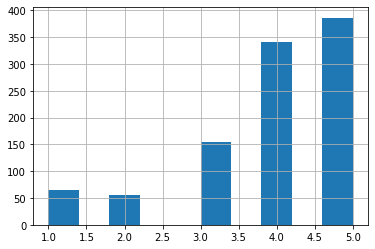

In [118]:
review_df['rating'].hist()

In [119]:
review_df[review_df['rating']<4].shape

(275, 2)

In [120]:
review_df[review_df['rating']>3].shape

(726, 2)

In [121]:
def rating_to_label(rating):
    if rating > 3:
        return 1
    else:
        return 0

review_df['y'] = review_df['rating'].apply(lambda x: rating_to_label(x))
review_df.head()

,rating,text,y
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...,1
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입...",1
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...,1
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...,1
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...,1


In [122]:
review_df['y'].value_counts()

1    726
0    275
Name: y, dtype: int64

----
### 4) 데이터셋 분리

In [123]:
from sklearn.model_selection import train_test_split

y = review_df['y']
x_train, x_test, y_train, y_test = train_test_split(tf_idf_vect, y, test_size=0.30)

In [124]:
print(x_train.shape)
print(x_test.shape)

(700, 3524)
(301, 3524)


----
### 5) 모델 학습

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train LR model
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

# classifiacation predict
y_pred = lr.predict(x_test)

In [126]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

----
### 6) 분류 모델의 평가

In [127]:
# classification result for test dataset
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.74
Precision : 0.738
Recall : 1.000
F1 : 0.849


AUC : 0.806


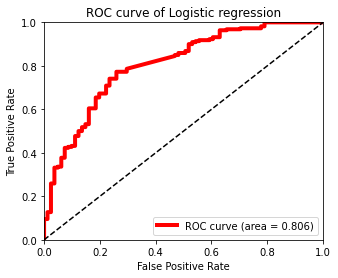

In [128]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC(Area Under the Curve)를 계산하여 출력
y_pred_probability = lr.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability) 
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, color='red', linewidth=4.0) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC curve of Logistic regression') 
plt.legend(loc="lower right")

In [129]:
from sklearn.metrics import confusion_matrix

# print confusion matrix
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  3  78]
 [  0 220]]


----
### 7) 샘플링 재조정

In [130]:
positive_random_idx = review_df[review_df['y']==1].sample(275, random_state=33).index.tolist()
negative_random_idx = review_df[review_df['y']==0].sample(275, random_state=33).index.tolist()

In [131]:
len(positive_random_idx)

275

In [132]:
len(negative_random_idx)

275

In [133]:
random_idx = positive_random_idx + negative_random_idx

In [134]:
len(random_idx)

550

In [135]:
X = tf_idf_vect[random_idx]

In [136]:
X

<550x3524 sparse matrix of type '<class 'numpy.float64'>'
	with 10480 stored elements in Compressed Sparse Row format>

In [137]:
# dataset split to train/test
y = review_df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [138]:
print(x_train.shape)
print(x_test.shape)

(412, 3524)
(138, 3524)


----
### 8) 모델 재학습

In [139]:
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

In [140]:
y_pred

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1])

In [141]:
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.74
Precision : 0.658
Recall : 0.814
F1 : 0.727


AUC : 0.828


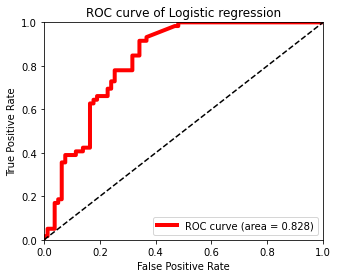

In [142]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC(Area Under the Curve)를 계산하여 출력
y_pred_probability = lr.predict_proba(x_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability) 
print("AUC : %.3f" % roc_auc)

# ROC curve를 그래프로 출력
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, color='red', linewidth=4.0) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC curve of Logistic regression') 
plt.legend(loc="lower right")

In [143]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[54 25]
 [11 48]]


----
## 2. 로지스틱 회귀 분석 결과를 이용한 감성 분석
### 1) 긍정/부정 키워드 분석

<BarContainer object of 3524 artists>

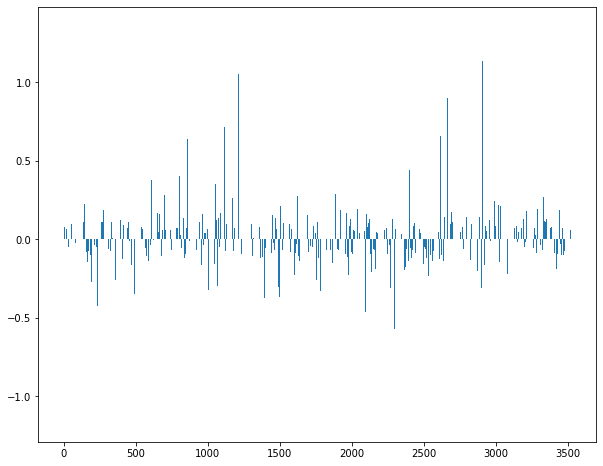

In [144]:
# logistic regression's coef
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [145]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(1.3546616880030016, 2346), (1.138019840698415, 2908), (1.0520419332543849, 1213), (0.9659051490769771, 2888), (0.8981700174409373, 26)]
[(-0.6724315184129809, 357), (-0.7110825548084946, 3463), (-0.7220355910100259, 1871), (-0.9885151695455561, 1259), (-1.164042051442666, 506)]


In [146]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=False)

In [147]:
coef_pos_index

In [148]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
for coef in coef_pos_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

이용 1.3546616880030016
추천 1.138019840698415
버스 1.0520419332543849
최고 0.9659051490769771
가성 0.8981700174409373
조식 0.8977045153118064
근처 0.8542240895658539
공간 0.7372012526817174
위치 0.736589403484912
맛집 0.7310974626171347
거리 0.7250984385668585
시설 0.7210729126357053
바다 0.71314978187576
분위기 0.709115408960054
정말 0.6593095535745904


In [149]:
for coef in coef_neg_index[:15]:
    print(invert_index_vectorizer[coef[1]], coef[0])

냄새 -1.164042051442666
별로 -0.9885151695455561
아무 -0.7220355910100259
화장실 -0.7110825548084946
그냥 -0.6724315184129809
모기 -0.6276475666438097
수건 -0.612691473548287
모텔 -0.6112305419708752
최악 -0.6096264310938102
느낌 -0.6067466186378433
음식 -0.5694079107974847
주위 -0.522409746732395
목욕 -0.5103021583277901
발코니 -0.49984340772008756
진짜 -0.4996253607995646


----
### 2) 긍정/부정 키워드 워드 클라우드 시각화

In [151]:
import pytagcloud
import webbrowser

In [152]:
tags = []
for coef in coef_pos_index[:30]:
    tags.append((invert_index_vectorizer[coef[1]], coef[0]))

In [153]:
tags

[('이용', 1.3546616880030016),
 ('추천', 1.138019840698415),
 ('버스', 1.0520419332543849),
 ('최고', 0.9659051490769771),
 ('가성', 0.8981700174409373),
 ('조식', 0.8977045153118064),
 ('근처', 0.8542240895658539),
 ('공간', 0.7372012526817174),
 ('위치', 0.736589403484912),
 ('맛집', 0.7310974626171347),
 ('거리', 0.7250984385668585),
 ('시설', 0.7210729126357053),
 ('바다', 0.71314978187576),
 ('분위기', 0.709115408960054),
 ('정말', 0.6593095535745904),
 ('주차', 0.6445154290142493),
 ('리조트', 0.6397555175566342),
 ('직원', 0.6396285205584581),
 ('사장', 0.611896115550979),
 ('더블', 0.5570928635711105),
 ('지역', 0.555395880648405),
 ('기분', 0.5474612283405224),
 ('해변', 0.5433671718861962),
 ('도로', 0.5394245217979089),
 ('도움', 0.5237126229269173),
 ('주차장', 0.5199050859555683),
 ('합리', 0.5162878781016559),
 ('시장', 0.4993408218040764),
 ('걱정', 0.49746359426328635),
 ('방문', 0.4819348375261315)]

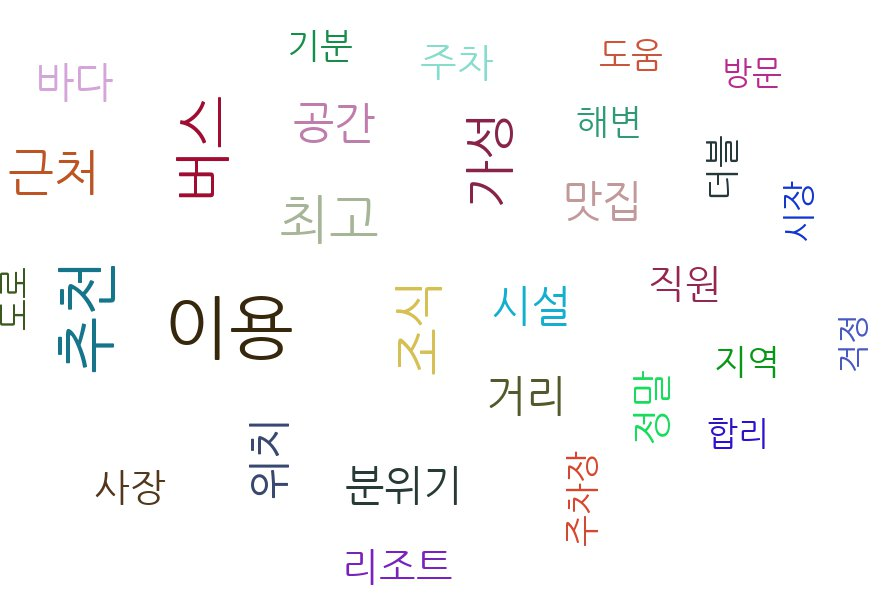

In [154]:
taglist = pytagcloud.make_tags(tags, maxsize = 50)
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

from IPython.display import Image 
Image(filename = 'wordcloud.jpg')

In [155]:
tags = []
for coef in coef_neg_index[:30]:
    tags.append((invert_index_vectorizer[coef[1]], coef[0]*(-1)))

In [156]:
tags

[('냄새', 1.164042051442666),
 ('별로', 0.9885151695455561),
 ('아무', 0.7220355910100259),
 ('화장실', 0.7110825548084946),
 ('그냥', 0.6724315184129809),
 ('모기', 0.6276475666438097),
 ('수건', 0.612691473548287),
 ('모텔', 0.6112305419708752),
 ('최악', 0.6096264310938102),
 ('느낌', 0.6067466186378433),
 ('음식', 0.5694079107974847),
 ('주위', 0.522409746732395),
 ('목욕', 0.5103021583277901),
 ('발코니', 0.49984340772008756),
 ('진짜', 0.4996253607995646),
 ('이틀', 0.49093403090500254),
 ('사진', 0.47800026821961655),
 ('예약', 0.46458853947179823),
 ('담배', 0.4568123571865297),
 ('제대로', 0.4523251178086479),
 ('대해', 0.4503026615173129),
 ('하루', 0.4486180359553416),
 ('사람', 0.4390787280573878),
 ('그닥', 0.4387517794092627),
 ('취소', 0.43019558958732523),
 ('에어컨', 0.42484449025006027),
 ('무난', 0.42265775386725324),
 ('곰팡이', 0.4217915620371959),
 ('이유', 0.4189971017551601),
 ('노후', 0.41478369565247986)]

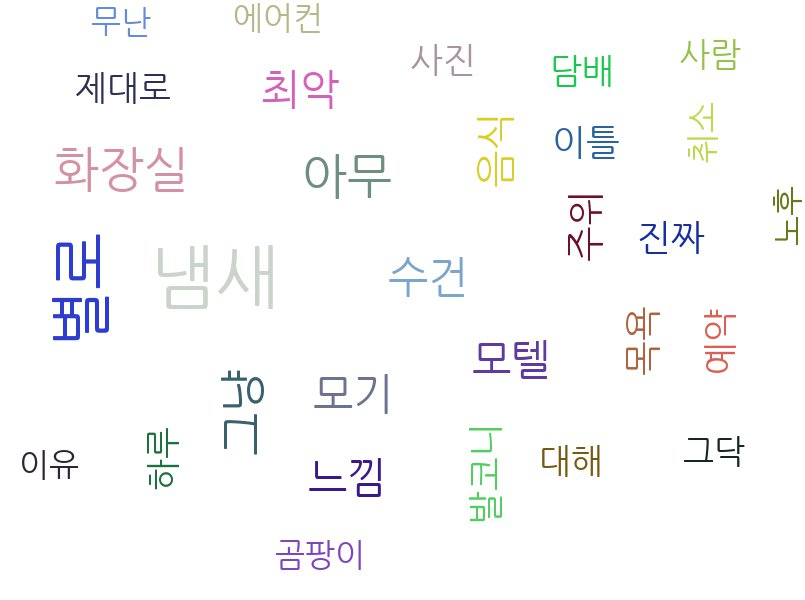

In [157]:
taglist = pytagcloud.make_tags(tags, maxsize = 50)
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

from IPython.display import Image 
Image(filename = 'wordcloud.jpg')

In [173]:
tags = [(x, count) for x, count in available_counter.items() if x not in jeju_hotel_stopwords]
sorted_by_value = sorted(tags, key=lambda tup: tup[1], reverse=True)[:50]
sorted_by_value

[('위치', 328),
 ('우리', 327),
 ('공항', 307),
 ('직원', 267),
 ('매우', 264),
 ('가격', 245),
 ('객실', 244),
 ('시설', 215),
 ('침대', 184),
 ('조식', 172),
 ('바다', 168),
 ('근처', 164),
 ('아침', 163),
 ('이용', 160),
 ('거리', 156),
 ('예약', 144),
 ('정말', 142),
 ('바로', 133),
 ('아주', 132),
 ('버스', 125),
 ('정도', 122),
 ('제공', 117),
 ('때문', 112),
 ('추천', 109),
 ('화장실', 106),
 ('생각', 103),
 ('시간', 102),
 ('다음', 101),
 ('욕실', 101),
 ('숙박', 99),
 ('체크', 97),
 ('식사', 97),
 ('가족', 94),
 ('다시', 93),
 ('주변', 92),
 ('해변', 92),
 ('무료', 89),
 ('다른', 88),
 ('택시', 87),
 ('사람', 81),
 ('모든', 81),
 ('수영장', 78),
 ('사용', 78),
 ('또한', 76),
 ('편의점', 75),
 ('방문', 74),
 ('영어', 74),
 ('공간', 73),
 ('서비스', 72),
 ('선택', 72)]

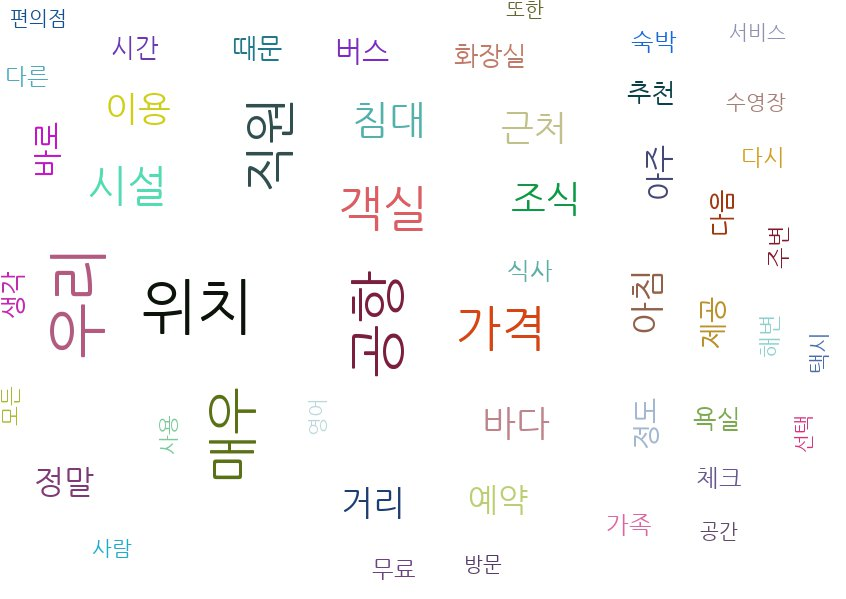

In [172]:
taglist = pytagcloud.make_tags(sorted_by_value, maxsize = 50)
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

from IPython.display import Image 
Image(filename = 'wordcloud.jpg')